# **Phase 2 Project Notebook - King County House Sales Dataset**

### Authors: Samantha, Ian, Sanjit

# Business Understanding

We framed our business problem from the perspective of Zillow, a company that relies on its ability to provide relevant and accurate "Zestimates" for houses listed to rent and to buy. These estimates are very often accurate in their depiction of a property's value; however, like most predictive models, there are always cases when it misses the mark. Often these errors have real-world consequences as external stakeholders can be affected financially because of inaccurate estimates. An undervalued prediction of a property for sale can affect homeowners looking to get a fair price for the home. These issues can cause harm to Zillow's reputation as the company looks to solidify its position as a leader in the online real estate marketplace.


From this (hypothetical) standpoint, our goal is to find attributes of a home that should be incorporated into the Zestimate model to minimize the harmful consequences of innacurate predictions on homeowners. By no means is this a comprehensive solution; rather, we hope to highlight the features available to us in the data that were the most indicative of a property's sale price. In addition, we seek to find ways in which feature engineering can play a role in fine-tuning the accuracy of our models and the ramifications it could have on improving the Zillow Zestimate.

# Data Understanding and Preparation

The data provided to us consists of information pertaining to over 20,000 house sales carried out between 2014 and 2015, located in the <code>data/kc_house_data.csv</code> file in this repository along with the <code>data/column_names.md</code> data dictionary summarizing the information contained in each of the 19 relevant features, not including the id column which can be discarded for our purposes. This data can be very helpful for us to see if we can find any correlations that the various features of a home may have with our target variable- price.

First we shall install the necessary packages that we will need going forward with our exploration.

In [2]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
%matplotlib inline

# Statistical Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats

# Predictive Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer

# Custom-made tools
import tools.helpers as th
import tools.data_preparation as dp
import tools.data_visualization as dv

### Importing the dataset and cleaning it

We import the csv file and run it through our first step of the cleaning process. <code>dp.initial_clean()</code> is a helper function can be found in the <code>"data_preparation.py"</code> file within the <code>"tools"</code> folder of this repository. 


What <code>dp.initial_clean()</code> does is: 

- Drop the <code>id</code> column. 
- Convert the <code>date</code> column values to DateTime format using <code>pd.to_datetime</code>.
- Convert the <code>'sqft_basement'</code> column values to float, coerce the '?' to NaN values.
- Mode fill <code>NaN</code> values in the columns: <code>waterfront</code>, <code>yr_renovated</code>, and <code>view</code>.
- Removes outliers using the `remove_outliers` function, dropping values that have a z-score higher than 3
- Adds a feature calculating each house's distance from the center of the zipcode with the highest average price

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
final_df = dp.initial_clean(df)

Using <code>.info()</code> we take a look at what our dataset looks like after our initial clean. It can be seen here that there are no <code>null</code> values and the values in all columns except <code>date</code> are either stored in <code>float64</code> or <code>int64</code> format.

In [4]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20552 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              20552 non-null  datetime64[ns]
 1   price             20552 non-null  float64       
 2   bedrooms          20552 non-null  int64         
 3   bathrooms         20552 non-null  float64       
 4   sqft_living       20552 non-null  int64         
 5   sqft_lot          20552 non-null  int64         
 6   floors            20552 non-null  float64       
 7   waterfront        20552 non-null  float64       
 8   view              20552 non-null  float64       
 9   condition         20552 non-null  int64         
 10  grade             20552 non-null  int64         
 11  sqft_above        20552 non-null  int64         
 12  sqft_basement     20552 non-null  float64       
 13  yr_built          20552 non-null  int64         
 14  yr_renovated      2055

### Plotting Histograms.

Let us now see if we can find anything interesting in the distributions of the columns in our dataset.

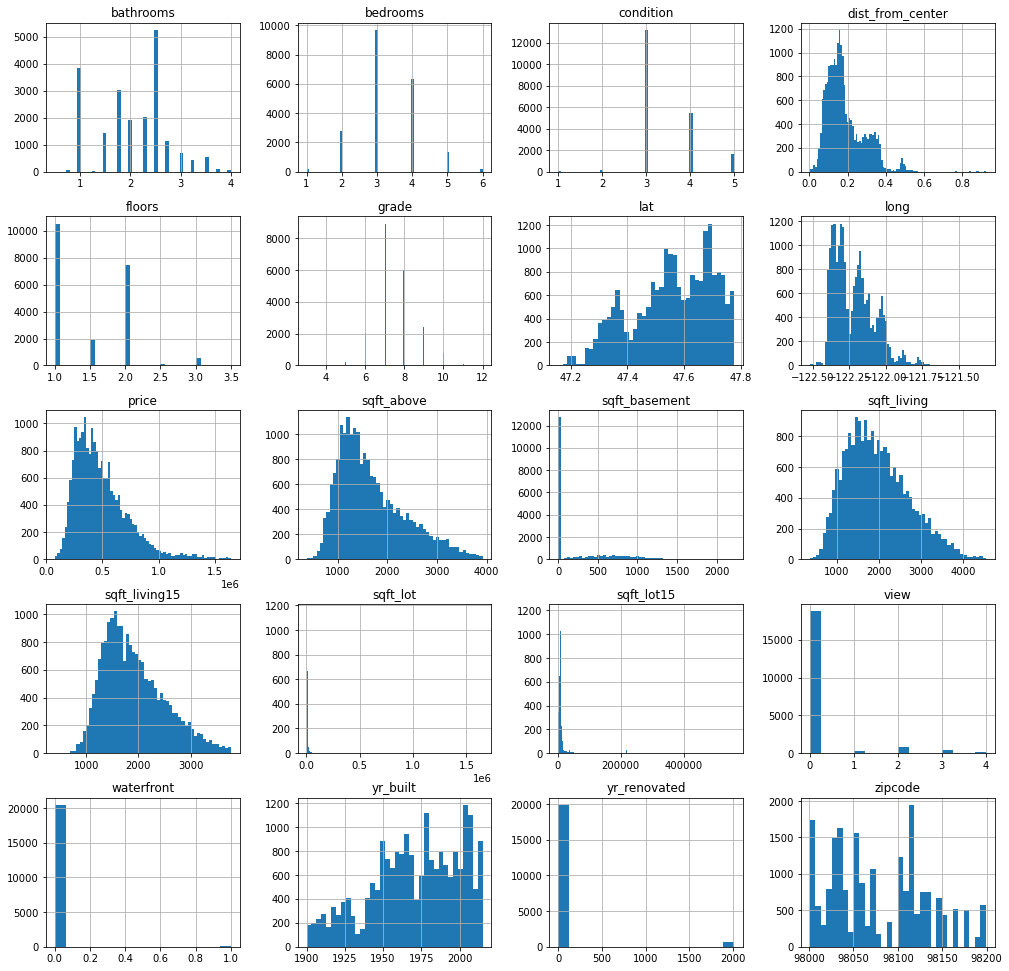

In [5]:
final_df.hist(figsize=(17, 17), bins='auto');

We can see from the above visualizations that our target column <code>price</code> is heavily skewed to the right. The same can be said about the columns <code>sqft_living</code> and <code>sqft_above</code> as well. The columns <code>long</code> and <code>sqft_living15</code> are right-skewed as well but seemingly not as much as the previously mentioned two columns. These columns will need to be log-transformed and scaled to make them more accurate predictors when attempting multiple linear regression.

 

### Finding correlations with  <code>price</code>.

Now we shall focus on our target <code>price</code> column and examine its relation with other columns in order to identify potential predictors for our first model.

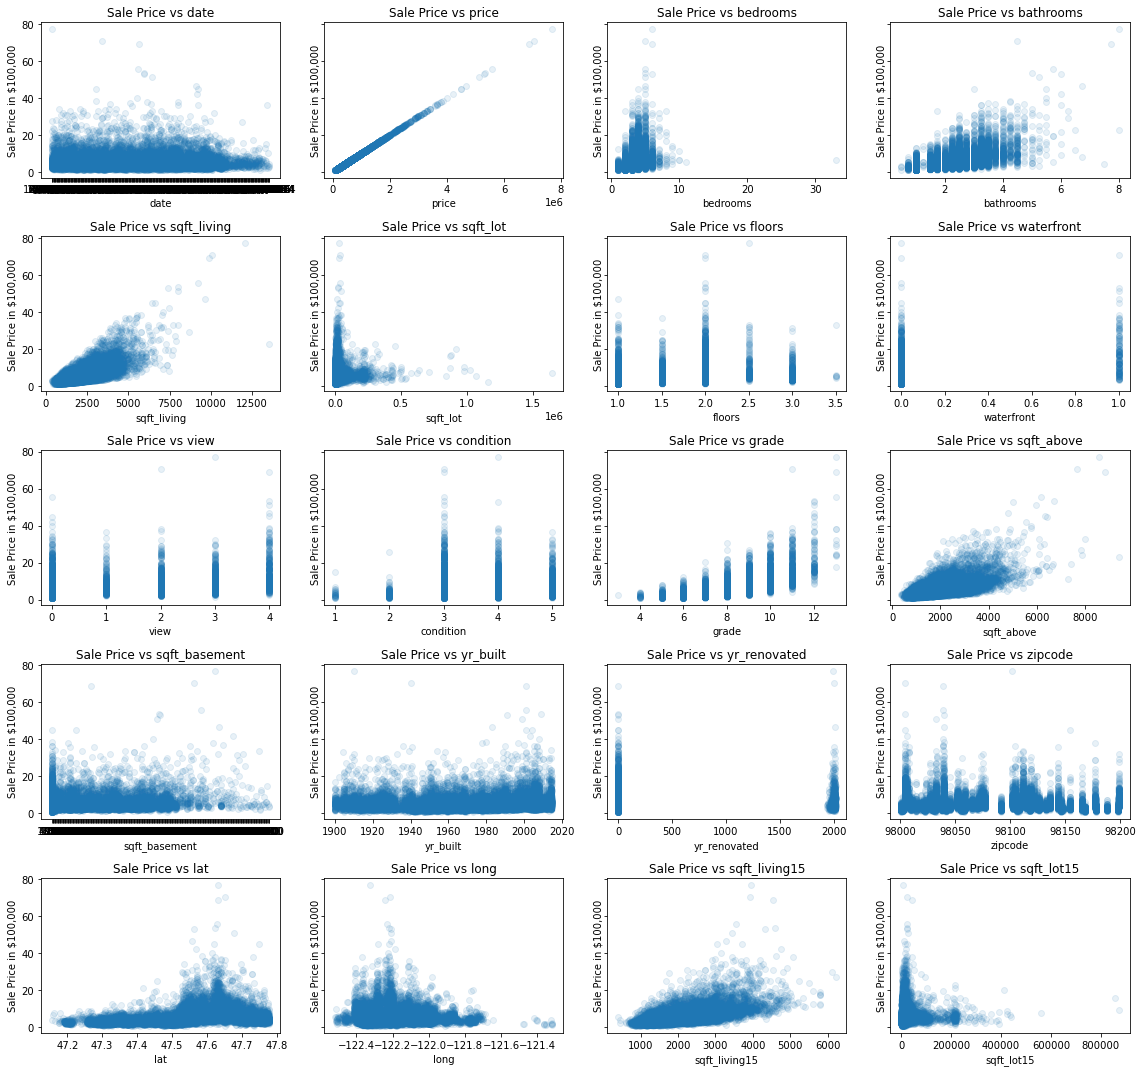

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), final_df.columns):
    ax.scatter(df[column], df['price'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

At first glance, we can infer that our <code>price</code> data may have a positive correlation with the following columns:

- <code>sqft_living</code>
- <code>sqft_above</code>
- <code>sqft_living15</code>

The columns <code>floors</code>, <code>waterfront</code>, <code>view</code>, <code>condition</code>, <code>grade</code> and <code>yr_renovated</code> can be treated as categorical variables.


Some salient features that were found to have high correlation with the sale price were:

- <code>sqft_living</code> - the area in square feet of the living space of the home
- <code>grade and condition</code> - two indicators of the subjective quality of the home
- <code>lat, long, and zipcode</code> - which conveyed valuable locational information regarding the homes
- <code>bedrooms and bathrooms</code> - two important metrics for most, if not all, homebuyers.

### Comparing Feature Multicollinearity

We use a custom function from the <code>data_visualization.py</code> file that takes a dataframe as an argument and returns a Seaborn visual of our features' multicollinearity. Every column from our dataset is compared against one another to identify how strong the correlation is between them. This can be helpful when selecting features that don't have strong multicollinearity, given how important this is for our predictive model to perform well.

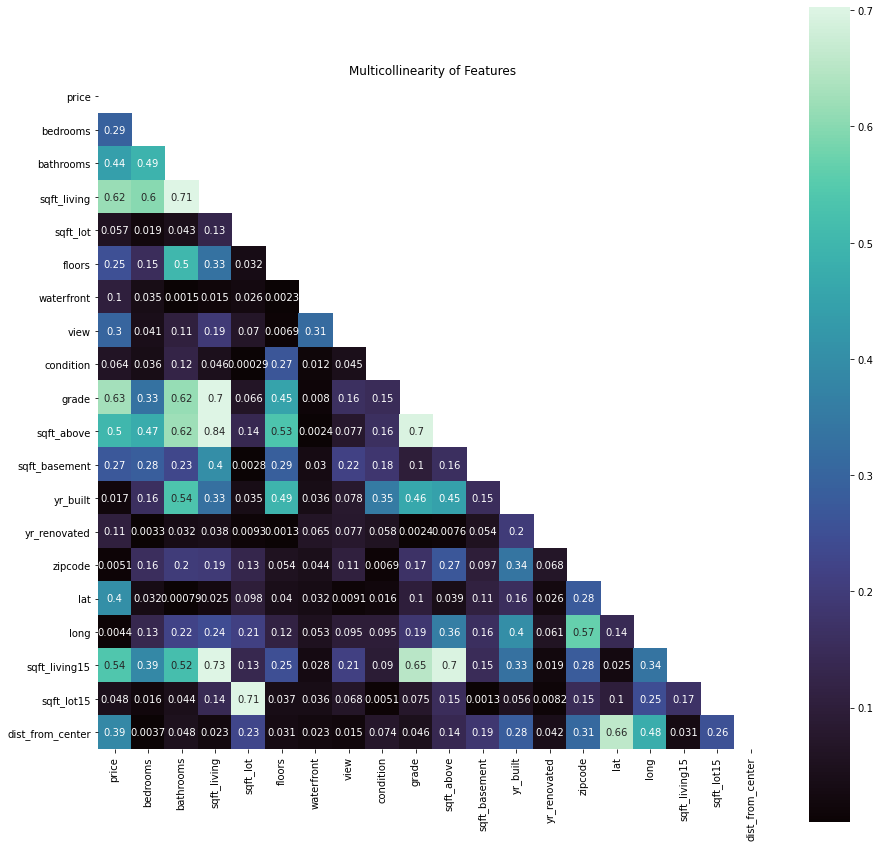

In [7]:
dv.corr_heatmap(final_df)

Some salient features that we see to have high correlation with the sale price are:

- <code>sqft_living</code> - the area in square feet of the living space of the home
- <code>grade and condition</code> - two indicators of the subjective quality of the home
- <code>lat, long, and zipcode</code> - which conveyed valuable locational information regarding the homes
- <code>bedrooms and bathrooms</code> - two important metrics for most, if not all, homebuyers.

## Identifying the most expensive Zip Codes with a Choropleth map

To create a high-quality visual for our analysis, we downloaded the <code>king_county_zipcodes.geojson</code> from <a href="https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/about">here</a>.

In [8]:
with open('data/king_county_zipcodes.geojson') as f:
    zipcode_geojson = json.load(f)

In [9]:
kc_zipcodes = final_df['zipcode'].unique()
zipcode_geojson['features'] = [feature for feature in zipcode_geojson['features'] if feature['properties']['ZIP'] in kc_zipcodes]

In [10]:
average_lat, average_long = final_df[['lat', 'long']].mean()
average_lat, average_long

(47.55811774523159, -122.21667594394663)

In [11]:
zipcode_avg_price = final_df.groupby('zipcode')[['price', 'lat', 'long']].mean().reset_index().sort_values('price', ascending=False)

zipcode_avg_price

zipcode         price        lat        long
24    98039  1.220882e+06  47.627306 -122.233412
3     98004  9.987986e+05  47.613671 -122.203206
25    98040  9.795895e+05  47.560094 -122.225426
48    98112  8.746252e+05  47.629481 -122.299000
47    98109  7.976321e+05  47.635806 -122.349833
..      ...           ...        ...         ...
61    98148  2.798186e+05  47.437482 -122.329339
0     98001  2.779730e+05  47.309013 -122.270668
20    98032  2.489277e+05  47.373700 -122.278758
64    98168  2.389863e+05  47.489773 -122.308000
1     98002  2.326047e+05  47.308752 -122.213311

[70 rows x 4 columns]

<br>We have created the <code>zipcode_avg_price</code> table above to help us make a Choropleth map that color-codes the various zipcodes in King County by their average home value. The most expsensive zipcode to purchase a home seems to be in 98039. We can utilize <code>folium</code> to produce a high-quality visual for our understanding of how prices are spread across King County, WA.

In [12]:
m = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    zoom_start=10
)

In [13]:
tooltips = folium.features.GeoJsonTooltip(
    fields=['ZIP']
)

In [14]:
highest_price, lat, long = zipcode_avg_price.iloc[0, 1:]

folium.Marker(
    location=[lat, long],
    tooltip=f"Average Price: ${highest_price:,.0f}"
).add_to(m);

In [15]:
choropleth = folium.Choropleth(
    geo_data=zipcode_geojson,
    data=zipcode_avg_price,
    columns=['zipcode', 'price'],
    key_on="feature.properties.ZIP",
    nan_fill_color=None,
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Sale Price ($)' 
)

choropleth.geojson.add_child(tooltips)
choropleth.add_to(m);

In [16]:
m

<br>Now that we have our visual, it can be easily seen that the zipcode that has the most expensive homes on average is **98039** *i.e.* ***Medina, WA***.<br> It isn't surprising to see that the more expensive regions happen to be surrounding the Seattle city area. And as we move further away from our most expensive neighborhood, we can observe that housing prices by zipcode are gradually starting to decrease.

# Modeling

Now that we have performed our cleaning and gathered an understanding of our dataset, we have identified some of the price predicting features that we can use. Therefore, we can begin to work on our baseline model.

In [17]:
X = final_df.drop('price', axis=1)
y = final_df['price']

## Baseline

In [18]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X, y)

DummyRegressor()

In [19]:
dummy_regr.score(X, y)

0.0

In [20]:
y_hat_dummy = dummy_regr.predict(X)
residuals_dummy = y_hat_dummy - y

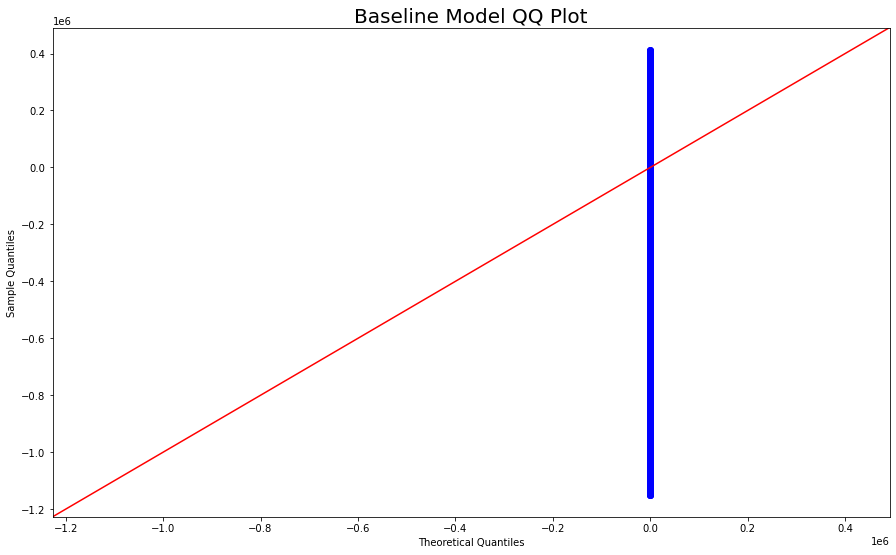

In [21]:
fig, ax = plt.subplots(figsize=(15, 9))

ax.set_title('Baseline Model QQ Plot', size=20)
fig = sm.graphics.qqplot(residuals_dummy, dist=stats.norm, line='45', ax=ax)

## Simple Linear Regression

<br>Here we perform a simple linear regression to predict <code>price</code> based on the <code>sqft_living</code> column. While we saw earlier that <code>grade</code> also has a good correlation with our predictor <code>price</code>, based on our domain understanding with experience in the industry, we felt that <code>sqft_living</code> is a stronger determinant of a property's price. Given there was such a minute difference in their respective correlations with <code>price</code>, we felt it was necessary that we use our domain knowledge to infer which predictor to use for our simple linear regression model.

In [22]:
#simple model comparing sqft_living with price
X_int = sm.add_constant(X['sqft_living'])
#fitting the linear regression model 
model = sm.OLS(y,X_int).fit()
#Getting the summary for our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.258e+04
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:26:34   Log-Likelihood:            -2.7897e+05
No. Observations:               20552   AIC:                         5.579e+05
Df Residuals:                   20550   BIC:                         5.580e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.588e+04   3765.190     25.464      0.000    8.85e+04    1.03e+05
sqft_living   201.1993      1.794    112.163      0.000     197.683     204.715
==============================================================================
Omnibus:                     3837.802   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8794.646
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                       5.389   Cond. No.                     5.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From our Simple Regression model above using <code>sqft_living</code> as a predictor, we have an *R-squared* score of 0.38. The R-squared score shows that we can only explain for 38% of the variation in the data. This is not a good enough estimation so we will have to try a more complex model to help us get closer predictions. 

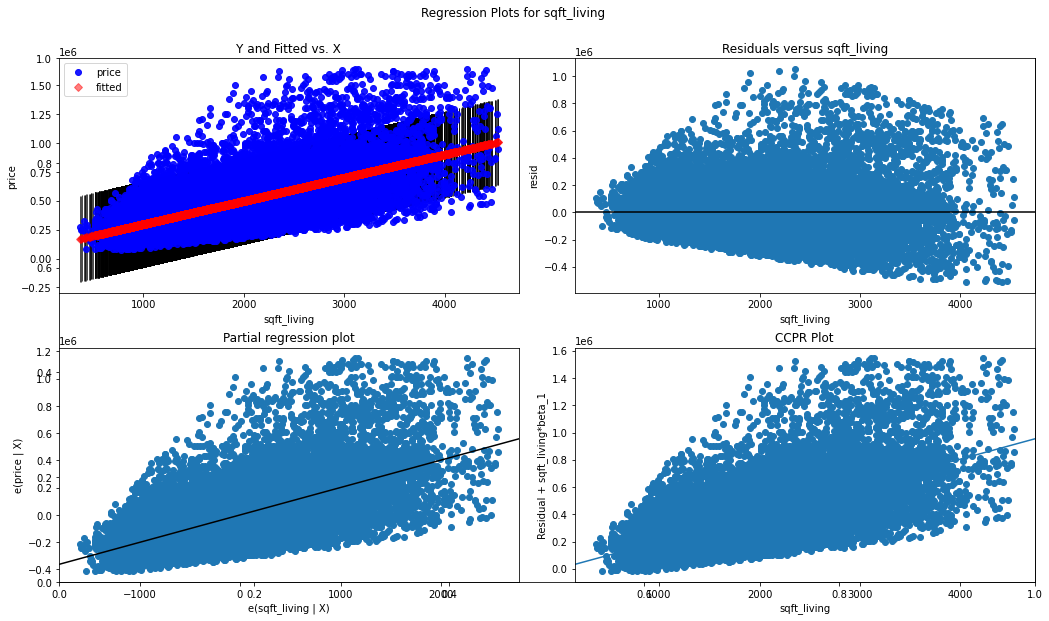

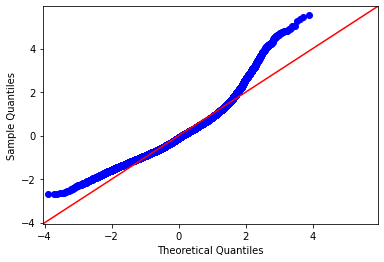

In [23]:
fig, ax = plt.subplots(figsize=(15, 9))

fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig)
fig = sm.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


### ^^^^ add description of above visual here

## Multiple Linear Regression

We can try performing a multiple linear regression using more than one feature to see if we can get a better *R-squared* score this time. But first, we need to identify the next best features while also taking into account the multicollinearity issues that may come up from having multiple predictors.

This function calculates pairwise correlations between each of the features in the dataset in order to determine which features to drop to decrease the conditional number of our multiple linear regression model. We decided on a cutoff of 0.70 for the correlation coefficient.

In [24]:
th.predictor_corrs(final_df, 0.70)

r
pairs                                 
(sqft_living, sqft_above)     0.835899
(sqft_living15, sqft_living)  0.727438
(sqft_lot, sqft_lot15)        0.708127
(sqft_living, bathrooms)      0.707537
(sqft_living, grade)          0.701825

It can be seen that there is a strong correlation between two of our strongest predictors of <code>price</code>: <code>grade</code> and <code>sqft_living</code>.

<br>We decided to drop the columns below to help us avoid any multicollinearity issues. Ultimately, we decided to let go of <code>grade</code> given our preference to avoid multicollinearity issues between our predictors.

In [25]:
# creating a new dataframe that removes collinear columns
df_test = final_df.drop(columns=[
    'date',
    'sqft_above',
    'grade',
    'sqft_living15', 
    'sqft_lot15', 
    'sqft_lot', 
    'bathrooms',
    'sqft_basement',
    'zipcode'
])
# viewing the first five rows to make sure the drop worked
df_test.head()

price  bedrooms  sqft_living  floors  waterfront  view  condition  \
0  221900.0         3         1180     1.0         0.0   0.0          3   
1  538000.0         3         2570     2.0         0.0   0.0          3   
2  180000.0         2          770     1.0         0.0   0.0          3   
3  604000.0         4         1960     1.0         0.0   0.0          5   
4  510000.0         3         1680     1.0         0.0   0.0          3   

   yr_built  yr_renovated      lat     long  dist_from_center  
0      1955           0.0  47.5112 -122.257          0.118478  
1      1951        1991.0  47.7210 -122.319          0.126901  
2      1933           0.0  47.7379 -122.233          0.110595  
3      1965           0.0  47.5208 -122.393          0.191864  
4      1987           0.0  47.6168 -122.045          0.188704

<br>We now set our <code>X</code> and <code>y</code> variables and then divide our test and training data. We 80/20 split the data with 20% of our data being used for testing. We use the parmater <code>random_state=42</code> to produce the same results across a different run.

In [26]:
X = pd.DataFrame(df_test.drop('price', axis=1))
y = df_test.price


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

<br>Then we fit a linear model to minimize the residual sum of the squares between the observed targets in our dataset and the targets predicted by the linear approximation. 

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# calculate train r squared and test r squared
print('Train Score:', lr.score(X_train, y_train))
print('Validation Score:', lr.score(X_test, y_test))

Train Score: 0.6355383866734114
Validation Score: 0.6283587556749932


This is a healthy looking difference between our Train and Test scores. Since the Train score is slightly higher, we can identify that our model is slightly overfit. But the difference between the two scores does not seem too high so our model seems to be able to be more general/holistic in its predictions based on its performance with the test data. More tests can be done with datasets from elsewhere to truly identify the model's capability.

<br>**Find RMSE**

Now that we have our *R-squared* values, we can identify the degree of variation or prediction could have in $ amounts. Therefore, we can have a fair understanding of how far off the actual home value, our prediction can be.

We can use <code>.predict()</code> to predict the <code>y</code> using the linear model made in the previous step.<br> Then we can compare our <code>y_test</code> data to our predictions so that we can gather our Root Mean Squared Error. This can tell us how far off by dollar amount our predictions are from the observed values.

In [28]:
predictions = lr.predict(X_test)


RMSE = mean_squared_error(y_test, predictions, squared=False) # False returns RMSE value
print('Second RMSE: $', round(RMSE, 2))

Second RMSE: $ 148512.14


<br>Our RMSE here shows that our current model's predictions can be off the mark from the true price value for a home by $148,512. Surely we must be able to do better than this on our next model. A prediction error of such a high amount could be a costly problem in the real estate marketplace as we find inaccurate valuations being perceived as true prices.

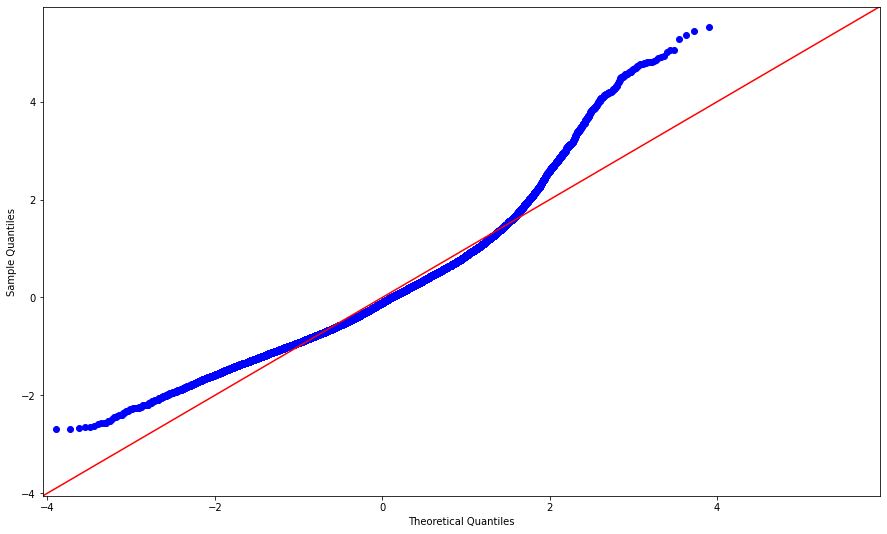

In [29]:
fig, ax = plt.subplots(figsize=(15, 9))
fig = sm.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)

Looking at the QQ plot helps us compare the distribution of our data and it can be see here that our data is slightly more skewed to the right. 



### ADD MORE HERE!!! ^^^^^

## MLR with Polynomial Features

We saw that the multiple linear regression alone didn't fit very well and our r-squared value still seemed a bit low. So, we tried to use the polynomial features function from sklearn to fit a polynomial line so that we can achieve a minimum error.
 

In [30]:
# log transform continuous variables
to_log = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.log_transform(df_test, to_log)

<br>First we log-transformed our continuous variables to maintain a more normal distribution within the respective columns.<br> Then we fit the <code>PolynomialFeatures</code> to our predictors. We set the degree to <code>2</code>. After this we split our dataset again in the same 80/20 format as before with 20% of our data being used as test data.

In [31]:
poly_2 = PolynomialFeatures(2) # 2 is the degree of the polynomial features

X = pd.DataFrame(
            poly_2.fit_transform(df_test.drop('price', axis=1))
)
y = df_test.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

<br>Now we can fit our linear regression model to the training data to get an R-squared value. This can then be compared with our test data.

In [32]:

lr.fit(X_train, y_train)

print('Train Score:', lr.score(X_train, y_train))
print('Validation Score:', lr.score(X_test, y_test))

Train Score: 0.7682923159868636
Validation Score: 0.7749244355392159


It is encouraging to see the amount of variance in the data being accounted for has increased. Also, a comparable score between out Training and test data means our model is fitting well.

**Find the RMSE**

We can predict <code>y</code> using the MLR model we made in the previous step.

In [33]:
predictions = lr.predict(X_test)

<br>Then we undo the log transform we performed on price to better interpret our model's RMSE.

In [34]:
y_test2 = np.exp(y_test)

# remove log transform off predictions
predictions2 = np.exp(predictions)

<br>We calculate the RMSE now to see how off our predictions may be now from the actual home value.

In [35]:
# calculate RMSE comparing 'y_test2' and 'predictions2'
RMSE = mean_squared_error(y_test2, predictions2, squared=False)
print('Final RMSE: $', round(RMSE, 2))

Final RMSE: $ 129404.2


The possibility of an erroneous prediction by as much as $129,404.2.

This is atleast still better than our previous model that had an RMSE of $148,512.14. This is a positive step as we come close to helping home-owners and potential buyers get an accurate price valuation.

### Cross Validation On Our Final Linear Regression Model

In [36]:
# 5-fold cross-validation to get the mean squared error through scikit-learn
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(lr, X, y, cv=5, scoring=mse)

In [37]:
print('Average MSE:', round(cv_5_results.mean(), 2))

Average MSE: 0.05


The average squared difference between the estimated values and the actual value is very small, at only 0.05. This is a good indicator that our forcasted or predicted price for homes is very close to the actual price these homes sold for. This gives us more assurance in the accuracy of our model and in our feature selection.

### Actual Prices vs Our Model Predictions

We can look at a scatterplot that looks at the correlation between our Predicted prices and our actual price.

Text(0, 0.5, 'Predictions')

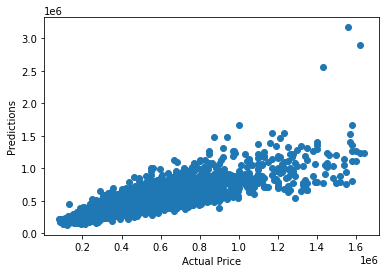

In [37]:
ax = plt.subplots()
fig = plt.scatter(y_test2, predictions2)


plt.xlabel('Actual Price')
plt.ylabel('Predictions')

We can see here that our model predictions and actual price values are not the same. If they were, we would be seeing a perfect line with a slope value equalling 1. Instead we are seeing that the scatterplot is leaning to the bottom, thereby indicating to us that most of the actual home prices are still higher than our predictions. Our predictions also seem to worsen as the price of a home increases. At the lowest prices we can see that there are some accurate predictions that would have fallen along the line <code>*y*=*x*</code>. But as we move along the *x-axis* we can see the scatter plot starts to spread out more- indicating that our predictions and the actual values start to vary more frequently.

In [38]:
# calculate the mean absolute percentage error
lr_mape = th.MAPE(y_test2, predictions2)
print("MAPE: ", round(lr_mape, 0), '%')

MAPE:  18.0 %


The mean absolute percentage error (MAPE) gives us further insight into the accuracy of our predictions. The average difference between the predicted value and the actual value for our final model is 18%. Generally, a MAPE of less than 20% is considered good. This tells us that our model is 82% accurate.


### Gradient Boost Regression ###

Gradient Boost Regression instead of Linear Regression using the same x and y variables from the previous model

In [39]:
# gradient boost regressor using the df_test
# small learning rate of 5% to minimize overfitting
# 400 boosting stages
# limit the number of nodes in the tree to 5
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(loss = 'ls', learning_rate = 0.05, 
                                         n_estimators = 400, max_depth = 5, min_samples_split = 2,)

In [40]:
# fit a gradient boost model for 'X_train' and 'y_train'
# this may take awhile to load
clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=400)

In [41]:
# calculate r squared for train and test data, train r squared will likely be higher due to overfitting
print('Train Score:', clf.score(X_train, y_train))
print('Validation Score', clf.score(X_test, y_test))

Train Score: 0.9061024326497263
Validation Score 0.8566540539739164


In [42]:
# predict the y_test values with the fitted gradient boost regression given the X_test values
predictions = clf.predict(X_test)

In [43]:
# we need to undue the log transform we performed on price to better interpret RMSE
y_test2 = np.expm1(y_test)

# remove log transform off predictions to better interpret RMSE
predictions2 = np.expm1(predictions)

In [44]:
RMSE = mean_squared_error(y_test2, predictions2, squared=False)
print('Gradient Boost RMSE: $', round(RMSE, 2))

Gradient Boost RMSE: $ 96252.89


Text(0, 0.5, 'Predictions')

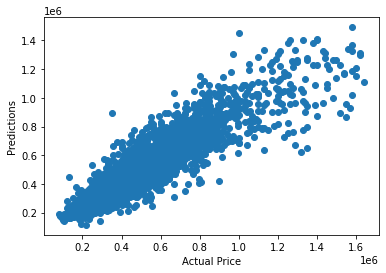

In [45]:
# plotting the actual home prices against the models predictions
plt.scatter(y_test2, predictions2)
plt.xlabel('Actual Price')
plt.ylabel('Predictions')

## Conclusions

Given our initial goal was to identify the best predictors to improve Zillow's Zestimate feature, an important takeaway from this study is our finding that a home's living space square footage and its location are two of the most important factors contributing to its price. In addition to this, we found that many metrics used to determine a house's value are largely dependent on one another. To provide an intuitive example, it would make sense that a larger home would recieve a higher grade, and this correlation could lead to overfitting of a simplistic model like multiple linear regression. As such, future iterations of this project should include more thorough use of the GradientBoostRegressor estimator from sklearn.ensemble to arrive at a more accurate model.

In addition, the use of coordinates and the presence of "nearest 15 neighbors" features in the initial dataset has led us to conclude that an implementation of the K-Nearest Neighbor algorithm to this and other similar datasets would be a fruitful endeavor. Only so much can be accomplished in a week of work, but throughout the course of this study we now understand that there are many avenues for us to take in improving the models as they exist now.